In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## library

In [3]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

def load_train_dataset_2(): #A supprimer
    root_dir = "/content/drive/MyDrive/ml_project_2_drive/ml_project_2/data/training/"
    image_dir = root_dir + "images/"
    gt_dir = root_dir + "groundtruth/"
    files = os.listdir(image_dir)
    n = len(files)

    np_X = [load_image(image_dir + files[i]) for i in range(n)]
    np_Y = [load_image(gt_dir + files[i]) for i in range(n)]

    torch_X = [torch.from_numpy(x).reshape(3, 400, 400) for x in np_X]
    torch_Y =[torch.from_numpy(y).reshape(1, 400, 400) for y in np_Y]

    return (torch_X, torch_Y)

def load_train_dataset():
    #root_dir = "../data/training/"
    root_dir = "/content/drive/MyDrive/ml_project_2_drive/ml_project_2/data/training/"
    image_dir = root_dir + "images/"
    gt_dir = root_dir + "groundtruth/"
    files = os.listdir(image_dir)
    n = len(files)

    to_tensor = T.ToTensor()
    imgs = [to_tensor(Image.open(image_dir + files[i])) for i in range(n)]
    gt_imgs = [to_tensor(Image.open(gt_dir + files[i])) for i in range(n)]
    return (imgs, gt_imgs)

In [4]:
def save_ckp(state, is_best, checkpoint_path, best_model_path):
    """
    state:            checkpoint we want to save
    is_best:          boolean to indicates if it is the best checkpoint
    checkpoint_path:  path to save checkpoint
    best_model_path:  path to save best model
    """
    f_path = checkpoint_path
    torch.save(state, f_path)
    # if it is a best model, min validation loss
    if is_best:
        best_fpath = best_model_path
        shutil.copyfile(f_path, best_fpath)

In [2]:
# FUNCTIONS FOR DATASET AUGMENTATION

#Constants
DIM_IMG = 400
DIM_IMG_CROP=DIM_IMG//2
NB_ROT = 10
ANGLE_ROTATION = 9

#Horizontal flip
def hor_flip(imgs):
    hflip_imgs = [T.functional.hflip(imgs[i]) for i in range(len(imgs))]
    return hflip_imgs

#Vertical flip
def vert_flip(imgs):
    vflip_imgs = [T.functional.vflip(imgs[i]) for i in range(len(imgs))]
    return vflip_imgs
    
#Rotation
def rotation(imgs):
    rot_imgs = [T.functional.rotate(imgs[i], ANGLE_ROTATION*(i+1), expand=False)
                for _ in range(NB_ROT)
                for i in range(len(imgs))
               ]
    return rot_imgs
    
#Crop and resize
def crop(imgs):
    cropped_imgs = [T.Resize(size=DIM_IMG)(T.FiveCrop(size=DIM_IMG_CROP)(imgs[i])[tuple_i])
                    for tuple_i in range(5)
                    for i in range(len(imgs))
                   ]
    return cropped_imgs

def compose_all_functions_for_data(imgs):
    #h = imgs + hor_flip(imgs)
    #v = h + vert_flip(h)
    #c = v + crop(v)
    #r = imgs + rotation(c)
    #return r
    r = imgs + rotation(imgs)
    return r

## Imports

In [5]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
import random
import os,sys
from PIL import Image
import torchvision.transforms as T
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

#from helper_functions import *

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Constants definition

In [7]:
CHECKPOINT_PATH ="/content/drive/MyDrive/ml_project_2_drive/ml_project_2/checkpoint/current_checkpoint_rot.pt"
BEST_MODEL_PATH ="/content/drive/MyDrive/ml_project_2_drive/ml_project_2/checkpoint/best_model_rot.pt"
NBR_EPOCHS = 5
BATCH_SIZE = 1
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 0
GAMMA = 1
K_FOLD = 4
VALIDATION_SET_IDX = 0
BATCH_SIZE_VAL = 5
SEED = 0

## Data set

In [8]:
class imagesDataset(Dataset): 
    def __init__(self, K_fold, validation_set_idx, batch_size_val, seed):
        X, Y = load_train_dataset()

        #tresholding ground_truth values
        Y = [(y > 0.5).long() for y in Y]
        shape_y = Y[0].shape
        
        #shuffling
        random.seed(seed)
        idx_list = list(range(len(X)))
        random.shuffle(idx_list)
        random.seed()
        X = [X[idx] for idx in idx_list]
        Y = [Y[idx] for idx in idx_list]
        
        #K_fold separation
        fold_size = len(X) // K_fold
        start_validation_idx = validation_set_idx * fold_size
        end_validation_idx = start_validation_idx + fold_size
        self.X_train = X[slice(0, start_validation_idx)] + X[slice(end_validation_idx, None)]
        self.Y_train = Y[slice(0, start_validation_idx)] + Y[slice(end_validation_idx, None)]
        self.X_validation = X[slice(start_validation_idx, end_validation_idx)]
        self.Y_validation = Y[slice(start_validation_idx, end_validation_idx)]

        #data augmentation
        self.X_train = compose_all_functions_for_data(self.X_train)
        self.Y_train = compose_all_functions_for_data(self.Y_train)
        self.X_validation = compose_all_functions_for_data(self.X_validation)
        self.Y_validation = compose_all_functions_for_data(self.Y_validation)
        self.n_samples = len(self.X_train)
        
        #casting into tensors
        self.X_train = torch.stack(self.X_train)
        self.X_validation = torch.stack(self.X_validation)
        self.Y_train = torch.reshape(torch.stack(self.Y_train) , (-1, shape_y[1], shape_y[2]))
        self.Y_validation = torch.reshape(torch.stack(self.Y_validation) , (-1, shape_y[1], shape_y[2]))

        #creating dataloader for validation data
        class dataset_validation(Dataset):
            def __init__(s,x,y):
                s.x = x
                s.y = y
                s.size = len(s.x)
            def __getitem__(s, index):
                return s.x[index], s.y[index]
            def __len__(s):
                return s.size
               
        self.validation_data_loader = torch.utils.data.DataLoader(
            dataset_validation(self.X_validation, self.Y_validation),
            batch_size = batch_size_val, shuffle = False)
        
        
    def __getitem__(self, index):
        return self.X_train[index], self.Y_train[index]

    def __len__(self):
        return self.n_samples
    
    def get_validation_dataloader(self):
        return self.validation_data_loader


dataset = imagesDataset(K_FOLD, VALIDATION_SET_IDX, BATCH_SIZE_VAL, SEED)
train_loader = torch.utils.data.DataLoader(dataset, batch_size = BATCH_SIZE, shuffle = True)
validation_dataloader = dataset.get_validation_dataloader()

## Model

In [9]:
def double_conv(nbr_channels_in, nbr_channels_out):
    return nn.Sequential(
      nn.Conv2d(nbr_channels_in, nbr_channels_out, (3,3), padding=(1, 1)),
      nn.BatchNorm2d(nbr_channels_out),
      nn.ReLU(),
      nn.Conv2d(nbr_channels_out, nbr_channels_out, (3,3), padding=(1, 1)),
      nn.ReLU(),
      nn.BatchNorm2d(nbr_channels_out),
)


def one_step_up(x, x_d_i, pre_up_i, up_i):
    return up_i(torch.cat((pre_up_i(x), x_d_i), dim=1))


class u_net(nn.Module):
    def __init__(self):
        super(u_net, self).__init__()

        self.down_pooling = nn.MaxPool2d(2, 2)

        # Convolution Downwards
        self.down_1 = double_conv(3, 64) 
        self.down_2 = double_conv(64, 128)
        self.down_3 = double_conv(128, 256)
        self.down_4 = double_conv(256, 512)
        self.middle =  double_conv(512, 1024)
        
        # Upconvolution
        self.pre_up_1 = nn.ConvTranspose2d(1024, 512, (2, 2), (2, 2))
        self.up_1 = double_conv(512 + 512, 512)
                
        self.pre_up_2 = nn.ConvTranspose2d(512, 256, (2, 2), (2, 2))
        self.up_2 = double_conv(256 + 256, 256)
          
        self.pre_up_3 = nn.ConvTranspose2d(256, 128, (2, 2), (2, 2))
        self.up_3 = double_conv(128 + 128, 128)

        self.pre_up_4 = nn.ConvTranspose2d(128, 64, (2, 2), (2, 2))
        self.up_4 = double_conv(64 + 64, 64)

        self.final_convolution = nn.Conv2d(64, 2, (1,1))
        

    def forward(self, x):
        x_d_1 = self.down_1(x)
        x_d_2 = self.down_2(self.down_pooling(x_d_1))
        x_d_3 = self.down_3(self.down_pooling(x_d_2))
        x_d_4 = self.down_4(self.down_pooling(x_d_3))

        x = self.middle(self.down_pooling(x_d_4))

        x = one_step_up(x, x_d_4, self.pre_up_1, self.up_1)
        x = one_step_up(x, x_d_3, self.pre_up_2, self.up_2)
        x = one_step_up(x, x_d_2, self.pre_up_3, self.up_3)
        x = one_step_up(x, x_d_1, self.pre_up_4, self.up_4)
        
        return self.final_convolution(x)


## Training

In [10]:
def train(n_epochs, data_loader, model, optimizer, scheduler, criterion, device, checkpoint_path, best_model_path):
    train_loader = data_loader
    validation_loader = train_loader.dataset.get_validation_dataloader()
    f1_max = 0
    
    for epoch in range(n_epochs):
        loss_list = []
        model.train()
        for (data, target) in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_list.append(loss.item())
        loss_epoch = np.mean(loss_list)

        model.eval()
        #computing F1 score on validation data
        tp, fp, fn = 0, 0, 0
        for (data, target) in validation_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            prediction = torch.argmax(output, dim = 1)
            confusions = prediction / target
            tp += torch.sum(confusions == 1).item()
            fp += torch.sum(confusions == float('inf')).item()
            fn += torch.sum(confusions == 0).item()
        f1_score_val = 2 * tp / (2 * tp + fp + fn)
        
        if f1_score_val > f1_max:
            torch.save(model.state_dict(), best_model_path)
            f1_max = f1_score_val

        checkpoint = {
            'epoch': epoch,
            'f1_max': f1_max,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.get_last_lr(),
        }
        
        save_ckp(checkpoint, False, checkpoint_path, best_model_path)

        #computing F1 score on training data
        tp, fp, fn = 0, 0, 0
        for (data, target) in train_loader:
            data, target = data.to(device), target.to(device)
            with torch.no_grad():
                output = model(data)
            prediction = torch.argmax(output, dim = 1)
            confusions = prediction / target
            tp += torch.sum(confusions == 1).item()
            fp += torch.sum(confusions == float('inf')).item()
            fn += torch.sum(confusions == 0).item()
        f1_score_train = 2 * tp / (2 * tp + fp + fn)

        print(f"Epoch {epoch} || Loss:{loss_epoch:.6f} || Training F1 {f1_score_train:.6f} || Validation F1 {f1_score_val:.6f} || Learning rate {scheduler.get_last_lr()[0]:.6f}"+"\n")  
        scheduler.step()
        
    return 

In [22]:
torch.save(model.state_dict(), BEST_MODEL_PATH)

In [11]:
LOAD_LAST_CHECKPOINT = False
LOAD_BEST_MODEL = True

model =  u_net().to(device)

if LOAD_LAST_CHECKPOINT and not LOAD_BEST_MODEL:
    checkpoint = torch.load(CHECKPOINT_PATH)
    model.load_state_dict(checkpoint['state_dict'])
    
if not LOAD_LAST_CHECKPOINT and LOAD_BEST_MODEL:
    model.load_state_dict(torch.load(BEST_MODEL_PATH))

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ExponentialLR(optimizer, GAMMA)
criterion = nn.CrossEntropyLoss()

In [21]:
train(NBR_EPOCHS, train_loader, model, optimizer, scheduler, criterion, device, CHECKPOINT_PATH, BEST_MODEL_PATH)

Epoch 0 || Loss:0.036420 || Training F1 0.900181 || Validation F1 0.811564 || Learning rate 0.001000



KeyboardInterrupt: ignored

In [24]:
root_test_dir = "/content/drive/MyDrive/ml_project_2_drive/ml_project_2/data/test_set_images/"
image_test_1 = root_test_dir + "test_11/test_11.png"

to_tensor = T.ToTensor()
imgt_1 = to_tensor(Image.open(image_test_1).resize((400,400)))

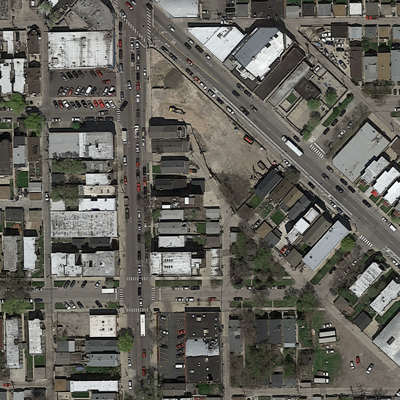

In [25]:
toPIL = T.ToPILImage()
toPIL(imgt_1)

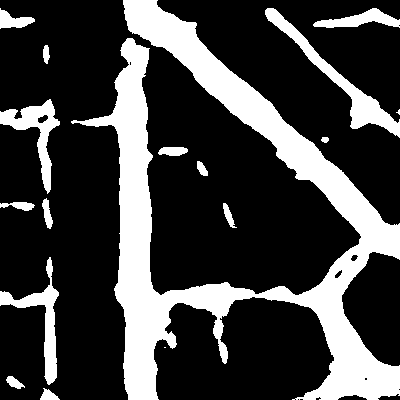

In [26]:
model.eval()
imgt_1 = imgt_1.reshape((1, 3, 400, 400))
output = model(imgt_1.to(device))
prediction = torch.argmax(output, dim = 1).cpu()
toPIL = T.ToPILImage()
toPIL(prediction.float())
#torch.all(prediction==0)

#Debugging

In [ ]:
def train_on_single_sample(n_epochs, im_test, gt_test, model, optimizer, scheduler, criterion, device, checkpoint_path, best_model_path):
    for epoch in range(n_epochs):
        data, target = im_test.to(device), gt_test.to(device)

        model.train()
        # Evaluate the network (forward pass)
        output = model(data)
        loss = criterion(output, target)

        # Compute the gradient
        optimizer.zero_grad()
        loss.backward()

        # Update the parameters of the model with a gradient step
        optimizer.step()

        #computing prediction to judge the model
        prediction = torch.argmax(output, dim = 1)

        #computing F1 score
        model.eval()
        tp, fp, fn = 0, 0, 0
        confusions = prediction / target
        tp += torch.sum(confusions == 1).item()
        fp += torch.sum(confusions == float('inf')).item()
        fn += torch.sum(confusions == 0).item()
        f1_score = 2 * tp / (2 * tp + fp + fn)
        
        #computing accuracy
        correct_predictions = prediction.eq(target)
        accuracy = correct_predictions.sum().float() / correct_predictions.nelement()
  

        print(f"Epoch {epoch} || Loss:{loss:.6f} || Training F1 {f1_score:.6f} || Training Accuracy : {accuracy}|| Learning rate {scheduler.get_last_lr()[0]:.6f}"+"\n")  
        #scheduler.step()
        
    return 

In [ ]:
model = u_net().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
#optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.5)
scheduler = ExponentialLR(optimizer, GAMMA)
criterion = nn.CrossEntropyLoss()

In [ ]:
im_test, gt_test = next(iter(train_loader))

In [ ]:
#fig1 = plt.figure(figsize=(10, 10))
toPIL = T.ToPILImage()
toPIL(im_test.reshape(3, 400, 400))

In [ ]:
#fig1 = plt.figure(figsize=(10, 10))
toPIL = T.ToPILImage()
toPIL(gt_test.float())

In [ ]:
train_on_single_sample(NBR_EPOCHS, im_test, gt_test, model, optimizer, scheduler, criterion, device, CHECKPOINT_PATH, BEST_MODEL_PATH)

In [ ]:
model.eval()
print(im_test.shape)
output = model(im_test.to(device))
prediction = torch.argmax(output, dim = 1).cpu()
#fig1 = plt.figure(figsize=(10, 10))
#plt.imshow(np.reshape(prediction, (400, 400)), cmap='Greys_r')
toPIL = T.ToPILImage()
toPIL(prediction.float())